# Applied Machine Learning Project
# Ayush Srivastava (MDS202113)
# Pragya Jaiswal (MDS202129)
# Rishika Tibrewal (MDS202135)
# Ved Prakash (MDS202153)

## Importing libraries and reading dataset

In [ ]:
# pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.ticker as mticker
from xgboost import plot_importance
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.dates import date2num
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Reliance_stock.csv')
data = data[['Date','Open','High','Low','Close']]
data["Date"]=pd.to_datetime(data["Date"])

data.head()

,Date,Open,High,Low,Close
0,2013-01-01,418.037415,419.325226,415.610443,416.402924
1,2013-01-02,418.037415,423.981079,417.319244,419.993866
2,2013-01-03,420.315826,426.952911,418.334595,426.333771
3,2013-01-04,426.903381,428.240692,422.767578,426.878632
4,2013-01-07,428.785553,431.410645,421.900787,424.278259


In [ ]:
data=data[["Date","Close"]]

In [ ]:
data.isna().sum()

Date     0
Close    2
dtype: int64

In [ ]:
data=data.dropna()

In [ ]:
data.isna().sum()

Date     0
Close    0
dtype: int64

## Exploratory Data Analysis

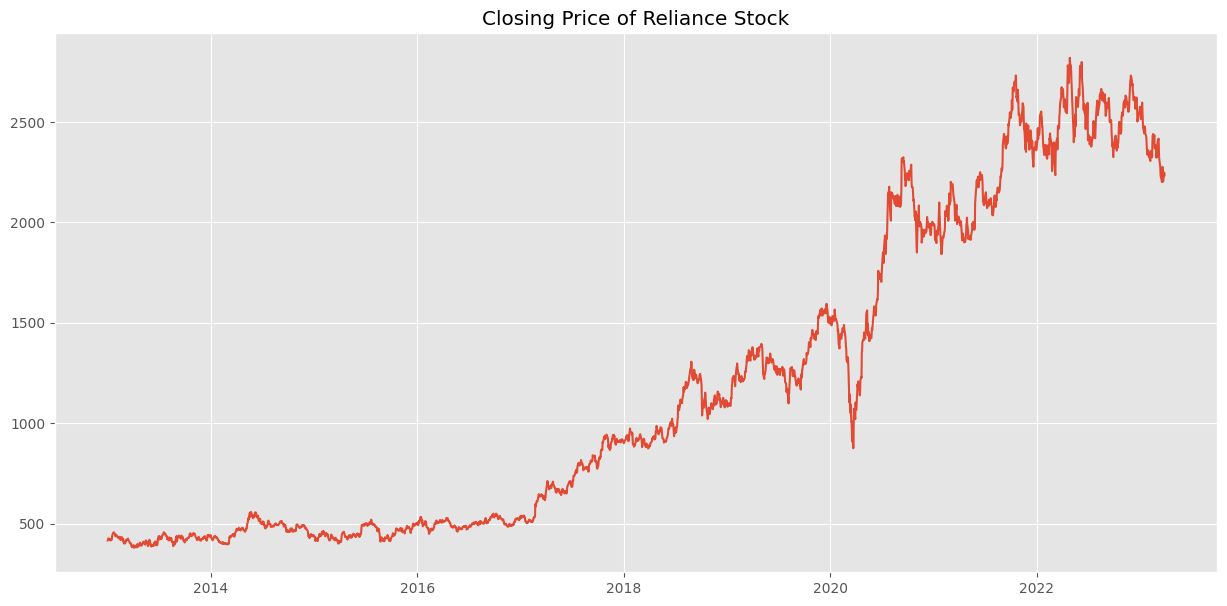

In [ ]:
plt.plot(data.set_index("Date")["Close"])
plt.title("Closing Price of Reliance Stock")
plt.show()

### Feature Engineering

In [ ]:
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = pd.DatetimeIndex(data['Date']).month

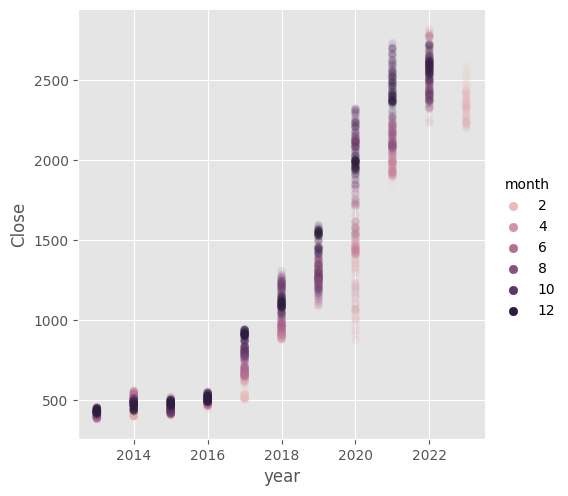

In [ ]:
sns.pairplot(data.dropna(),hue='month',x_vars=['year'], y_vars='Close', height=5,plot_kws={'alpha':0.15, 'linewidth':0})
plt.show()

In [ ]:
# Function to create lagged values
def df_shift(df,lag=0, start=1, skip=1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(start,lag+1,skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = (skip - 1)
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=skip
        df = pd.concat([df, dfn], axis=1)
    return df

In [ ]:
# Creating lagged values of Close Price with lag= 1,3,5,7
data = df_shift(data[['Date','Close']], lag = 10, start = 1, skip = 2,rejected_columns=['Date'])

In [ ]:
data.head()

,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9
0,2013-01-01,416.402924,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,419.993866,416.402924,NaN,NaN,NaN,NaN
2,2013-01-03,426.333771,419.993866,NaN,NaN,NaN,NaN
3,2013-01-04,426.878632,426.333771,416.402924,NaN,NaN,NaN
4,2013-01-07,424.278259,426.878632,419.993866,NaN,NaN,NaN


In [ ]:
# Creating rolling mean of close price for different window sizes
data["roll_7"]=data["Close"].rolling(7).mean()
data["roll_14"]=data["Close"].rolling(14).mean()
data["roll_25"]=data["Close"].rolling(25).mean()

In [ ]:
data.head(15)

,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9,roll_7,roll_14,roll_25
0,2013-01-01,416.402924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,419.993866,416.402924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,426.333771,419.993866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,426.878632,426.333771,416.402924,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-07,424.278259,426.878632,419.993866,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-01-08,421.331207,424.278259,426.333771,416.402924,NaN,NaN,NaN,NaN,NaN
6,2013-01-09,422.346588,421.331207,426.878632,419.993866,NaN,NaN,422.509321,NaN,NaN
7,2013-01-10,421.034027,422.346588,424.278259,426.333771,416.402924,NaN,423.170907,NaN,NaN
8,2013-01-11,416.006683,421.034027,421.331207,426.878632,419.993866,NaN,422.601310,NaN,NaN
9,2013-01-14,419.795746,416.006683,422.346588,424.278259,426.333771,416.402924,421.667306,NaN,NaN


## Anomaly Detection

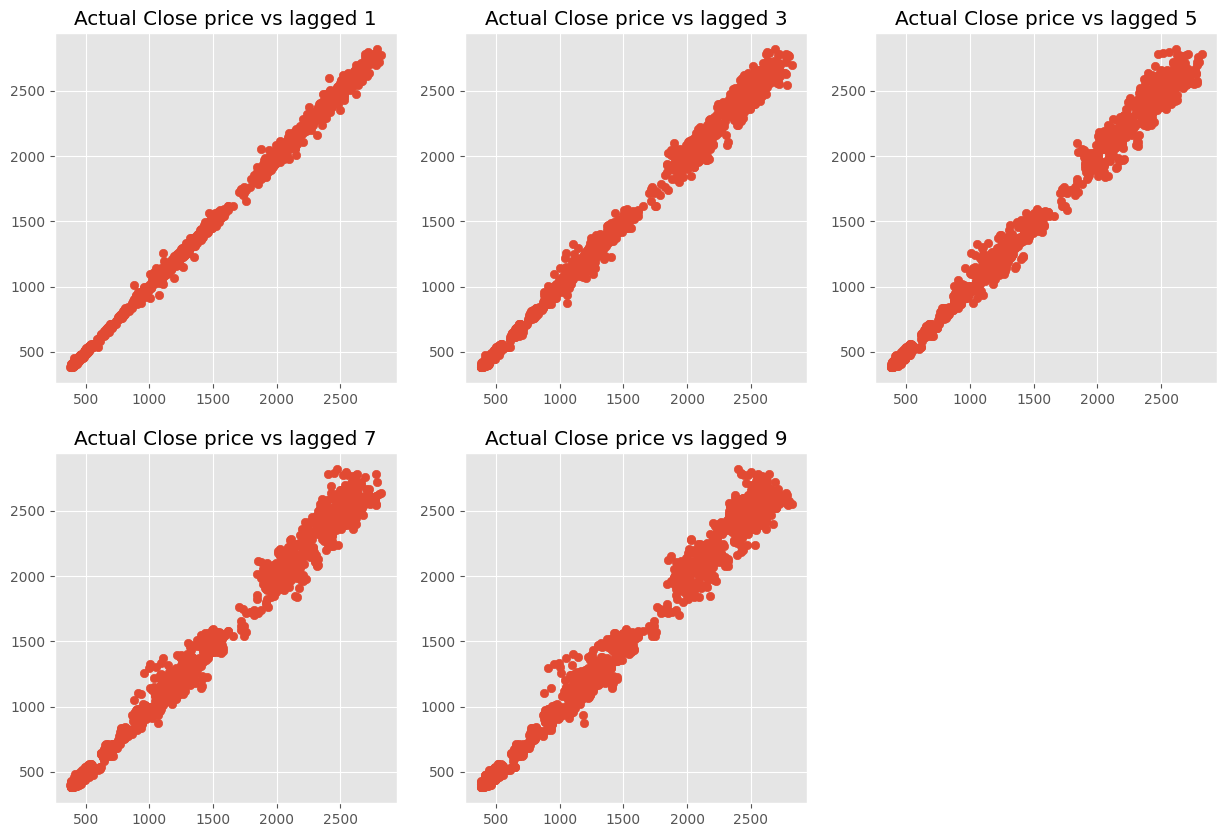

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.scatter(data['Close'],data['Close_1'])
plt.title('Actual Close price vs lagged 1')
plt.subplot(2,3,2)
plt.scatter(data['Close'],data['Close_3'])
plt.title('Actual Close price vs lagged 3')
plt.subplot(2,3,3)
plt.scatter(data['Close'],data['Close_5'])
plt.title('Actual Close price vs lagged 5')
plt.subplot(2,3,4)
plt.scatter(data['Close'],data['Close_7'])
plt.title('Actual Close price vs lagged 7')
plt.subplot(2,3,5)
plt.scatter(data['Close'],data['Close_9'])
plt.title('Actual Close price vs lagged 9')
plt.show()

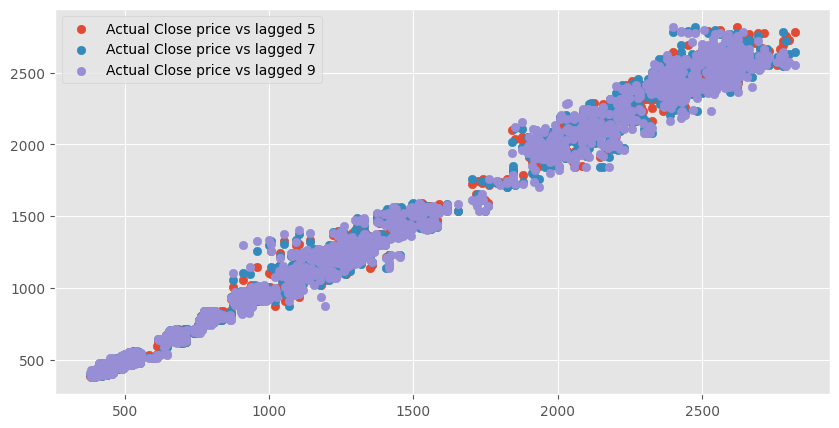

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(data['Close'],data['Close_5'],label='Actual Close price vs lagged 5')
plt.scatter(data['Close'],data['Close_7'],label='Actual Close price vs lagged 7')
plt.scatter(data['Close'],data['Close_9'],label='Actual Close price vs lagged 9')
plt.legend()
plt.show()

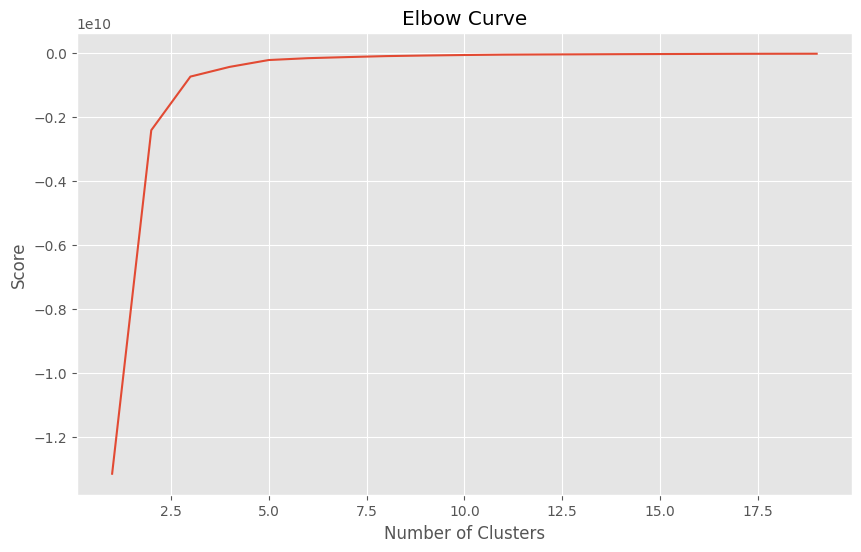

In [ ]:
n_cluster = range(1, 20)
temp = data.iloc[:,1:].dropna().values
kmeans = [KMeans(n_clusters=i).fit(temp) for i in n_cluster]
scores = [kmeans[i].score(temp) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

From the elbow curve, we can say that we need 3 clusters for the data.

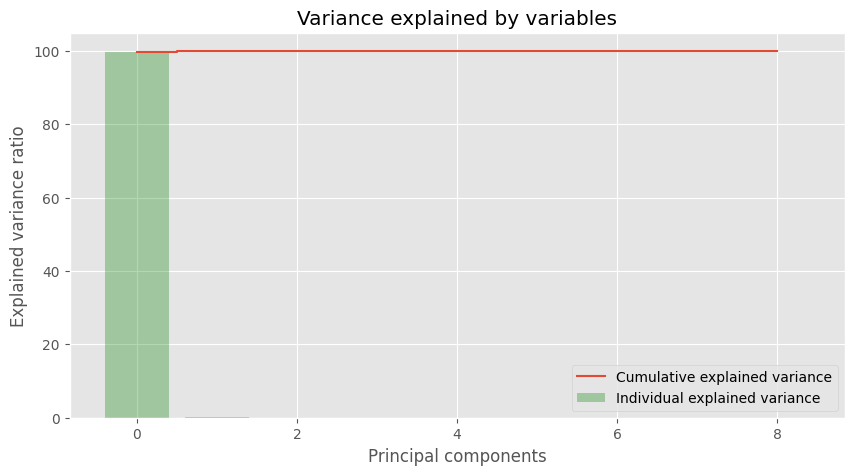

In [ ]:
X_std = StandardScaler().fit_transform(temp)

mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='Individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.title("Variance explained by variables")
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

Almost all variance is being explained by 2 dimensions (using PCA), and drop other variables for clustering. 

In [ ]:
X_std = StandardScaler().fit_transform(temp)
k_data = pd.DataFrame(X_std)
pca = PCA(n_components=2)
k_data = pca.fit_transform(k_data)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(k_data)

In [ ]:
kmeans = KMeans(n_clusters=3).fit(np_scaled)
data=data.dropna()
data['cluster'] = kmeans.predict(np_scaled)
data = data.reset_index()
data['principal_feature1'] = np_scaled[:,0]
data['principal_feature2'] = np_scaled[:,1]
data['cluster'].value_counts()

1    1561
2     478
0     418
Name: cluster, dtype: int64

In [ ]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = data[i]
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i]=np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.25
distance = getDistanceByPoint(np_scaled, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
data['anomaly'] = (distance >= threshold).astype(int)

In [ ]:
data.head(15)

,index,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9,roll_7,roll_14,roll_25,cluster,principal_feature1,principal_feature2,anomaly
0,24,2013-02-04,439.186951,442.802673,445.477325,444.561005,453.476501,455.705353,442.898198,445.403022,434.785665,1,-0.965989,0.183181,0
1,25,2013-02-05,433.268066,439.186951,439.162170,437.280029,451.817230,457.191284,440.248317,445.877101,435.460271,1,-0.969562,0.272849,0
2,26,2013-02-06,433.713837,433.268066,442.802673,445.477325,444.561005,453.476501,438.698722,445.369415,436.009070,1,-0.970443,0.250492,0
3,27,2013-02-07,432.351746,433.713837,439.186951,439.162170,437.280029,451.817230,437.994681,444.403571,436.249789,1,-0.973502,0.223649,0
4,28,2013-02-08,427.720642,432.351746,433.268066,442.802673,445.477325,444.561005,435.458012,442.408201,436.283469,1,-0.975206,0.272393,0
5,29,2013-02-11,430.122864,427.720642,433.713837,439.186951,439.162170,437.280029,434.166683,440.580880,436.517253,1,-0.978361,0.207049,0
6,30,2013-02-12,433.614777,430.122864,432.351746,433.268066,442.802673,445.477325,432.854126,438.896844,437.008596,1,-0.977217,0.241424,0
7,31,2013-02-13,435.373108,433.614777,427.720642,433.713837,439.186951,439.162170,432.309291,437.603745,437.529657,1,-0.978686,0.167918,0
8,32,2013-02-14,424.005859,435.373108,430.122864,432.351746,433.268066,442.802673,430.986119,435.617218,437.648530,1,-0.980708,0.224785,0
9,33,2013-02-15,418.928986,424.005859,433.614777,427.720642,433.713837,439.186951,428.873997,433.786360,437.765422,1,-0.984249,0.293807,0


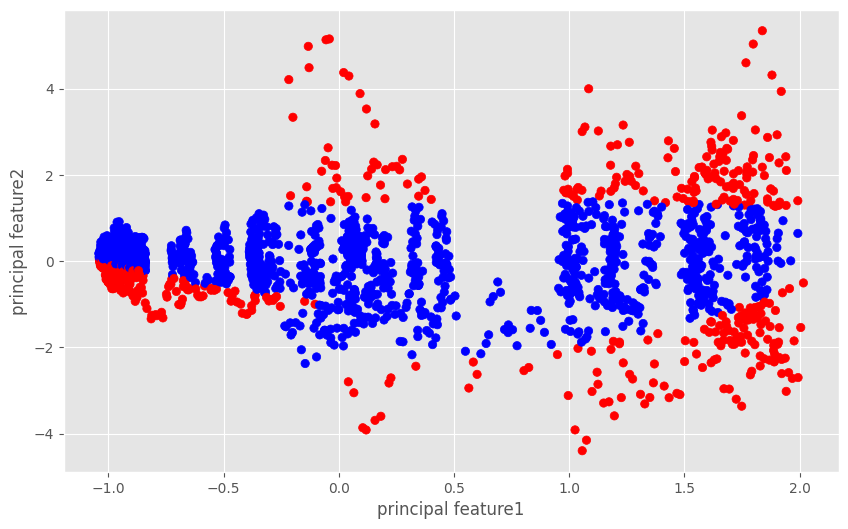

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(data['principal_feature1'], data['principal_feature2'], c=data["anomaly"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show()

Red values are anomalies, whereas the blue ones aren't. 

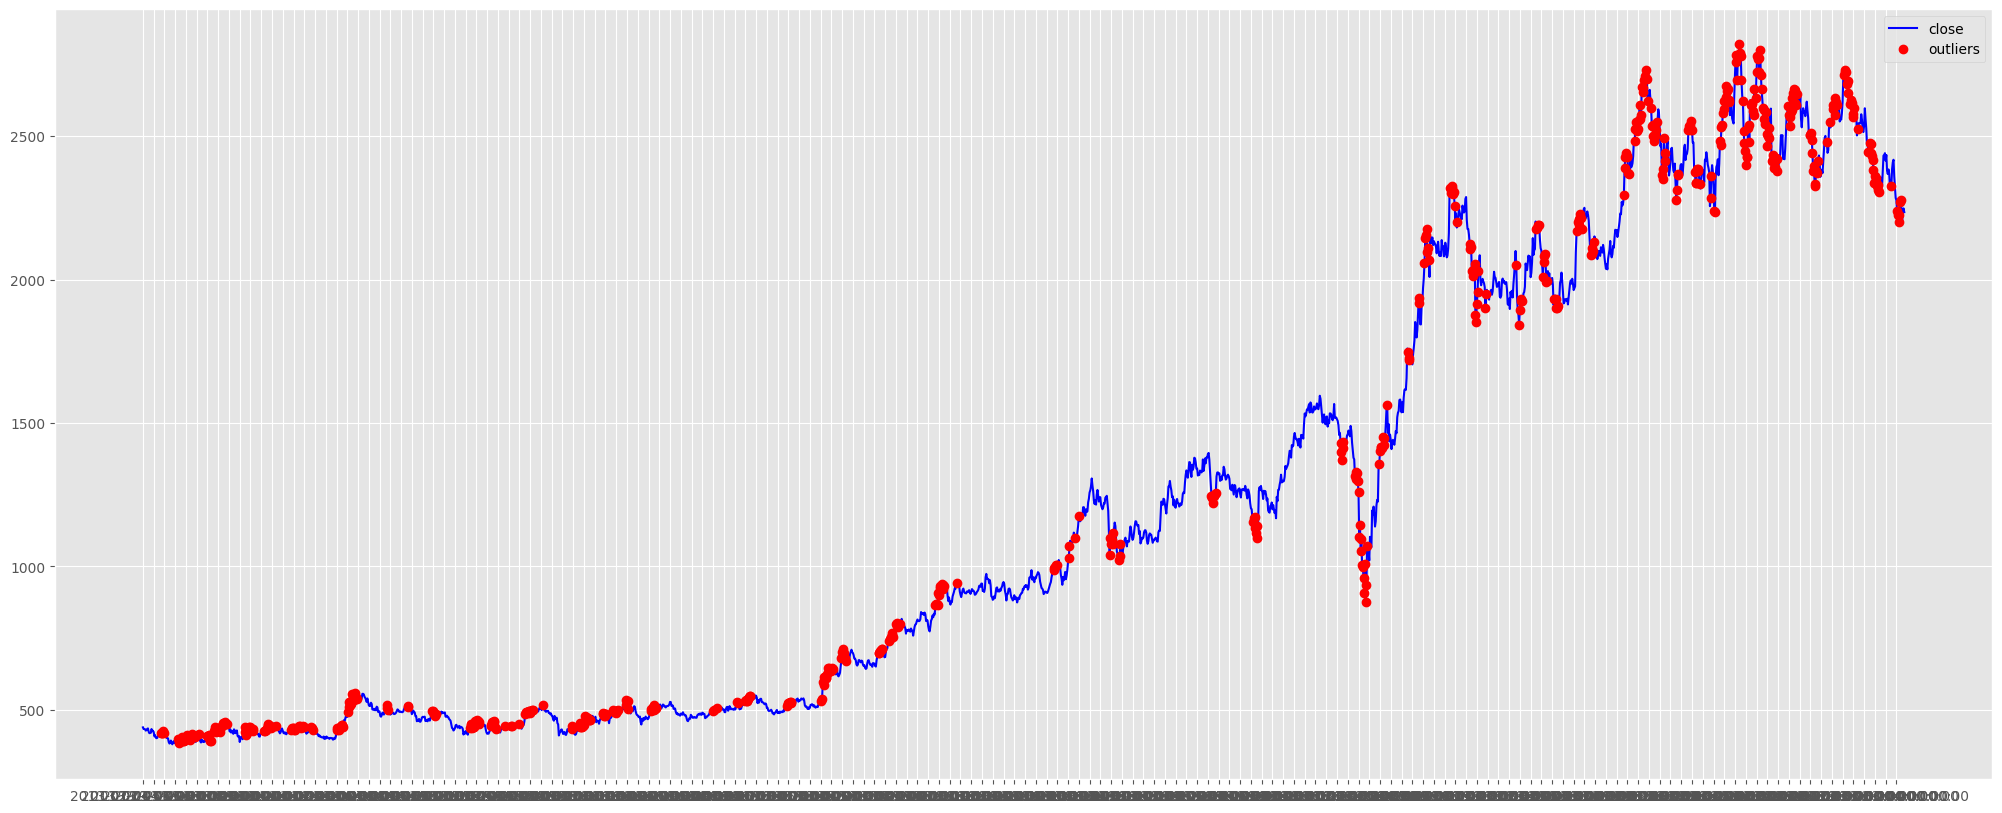

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(data['Close'], label='close',c='b')
plt.plot(data['Close'], 'o', label='outliers',markevery=data.loc[data['anomaly'] == 1].index.tolist(),c='r')
plt.xticks(np.arange(data.shape[0])[::15],pd.DatetimeIndex(data['Date'][::15]))
plt.legend()
plt.show()

## Linear Regression



In [ ]:
data.head()

,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9,roll_7,roll_14,roll_25
0,2013-01-01,416.402924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,419.993866,416.402924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,426.333771,419.993866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,426.878632,426.333771,416.402924,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-07,424.278259,426.878632,419.993866,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X=np.arange(len(data.index))
X=X.reshape(-1,1)
y=data["Close"].values
reg = LinearRegression().fit(X,y)
reg.score(X, y)

0.8791274211866671

In [ ]:
reg.coef_

array([0.99073177])

In [ ]:
y_pred = reg.predict(X)

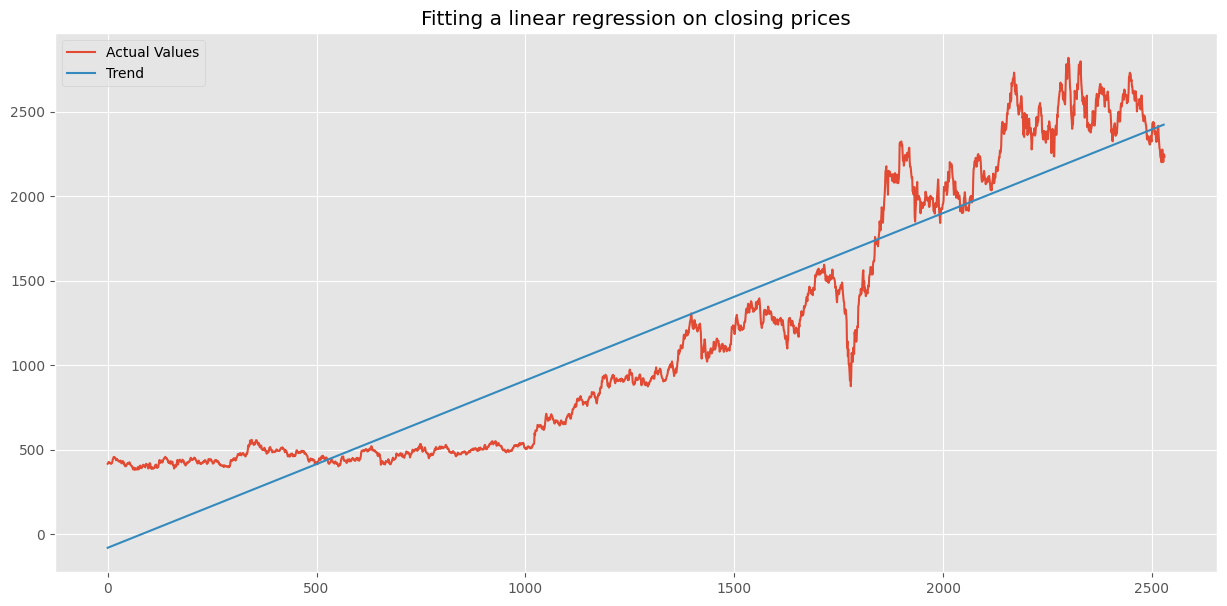

In [ ]:
plt.plot(data["Close"],label="Actual Values")
plt.plot(y_pred,label="Trend")
plt.legend(loc='best')
plt.title("Fitting a linear regression on closing prices")
plt.show()

## Seasonal Time Series Decomposition

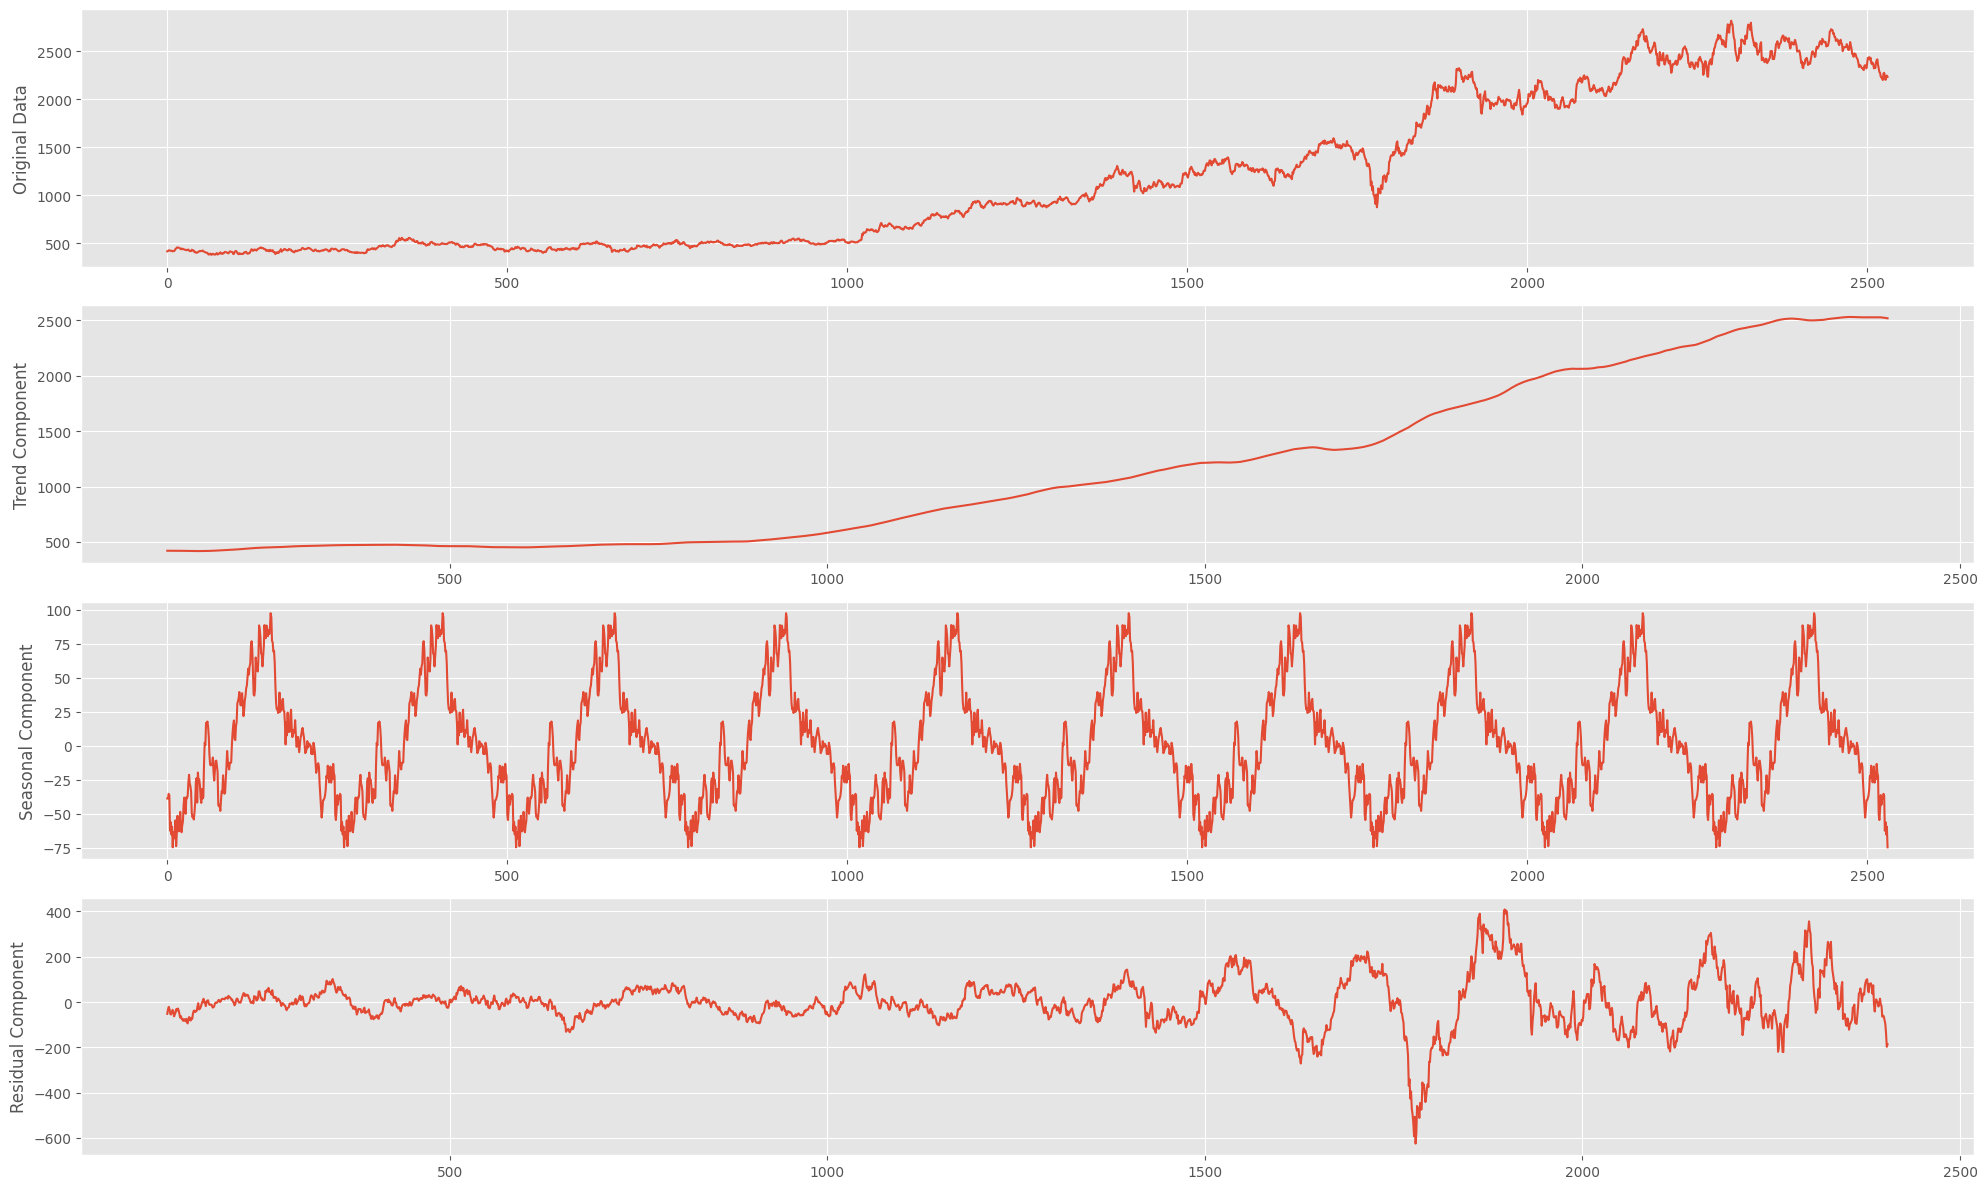

In [ ]:
# Decompose data into its components
# No of trading days in a year is about 252
result = seasonal_decompose(data["Close"], model='additive', period=252)

# Plot the original data and its components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
ax1.plot(data["Close"])
ax1.set_ylabel('Original Data')
ax2.plot(result.trend)
ax2.set_ylabel('Trend Component')
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal Component')
ax4.plot(result.resid)
ax4.set_ylabel('Residual Component')
plt.tight_layout()
plt.show()

In [ ]:
def stationarity(data):
  print("Observations of Dickey-fuller test")
  dftest = adfuller(data.fillna(0),autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
  for key,value in dftest[4].items():
      dfoutput['critical value (%s)'%key]= value
  print(dfoutput)

In [ ]:
stationarity(result.resid)

Observations of Dickey-fuller test
Test Statistic                -7.098251e+00
p-value                        4.233675e-10
#lags used                     2.700000e+01
number of observations used    2.501000e+03
critical value (1%)           -3.432967e+00
critical value (5%)           -2.862696e+00
critical value (10%)          -2.567386e+00
dtype: float64


The residuals are stationary.

## XGBoost

In [ ]:
# Creates time series features from datetime index
def create_features(df, label=None):
  df['date'] = df.Date
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  
  X = df[['dayofweek','quarter','month','year',
          'dayofyear','dayofmonth','weekofyear']]
  if label:
      y = df[label]
      return X, y
  return X

In [ ]:
X, y = create_features(data, label='Close')
features_and_target = pd.concat([X, y], axis=1)

In [ ]:
features_and_target.head(10)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
24,0,1,2,2013,35,4,6,439.186951
25,1,1,2,2013,36,5,6,433.268066
26,2,1,2,2013,37,6,6,433.713837
27,3,1,2,2013,38,7,6,432.351746
28,4,1,2,2013,39,8,6,427.720642
29,0,1,2,2013,42,11,7,430.122864
30,1,1,2,2013,43,12,7,433.614777
31,2,1,2,2013,44,13,7,435.373108
32,3,1,2,2013,45,14,7,424.005859
33,4,1,2,2013,46,15,7,418.928986


In [ ]:
train= data.iloc[:2277, 0:2]
test=data.iloc[2277:, 0:2]
X_train, y_train = create_features(train, label='Close')
X_test, y_test = create_features(test, label='Close')

In [ ]:
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

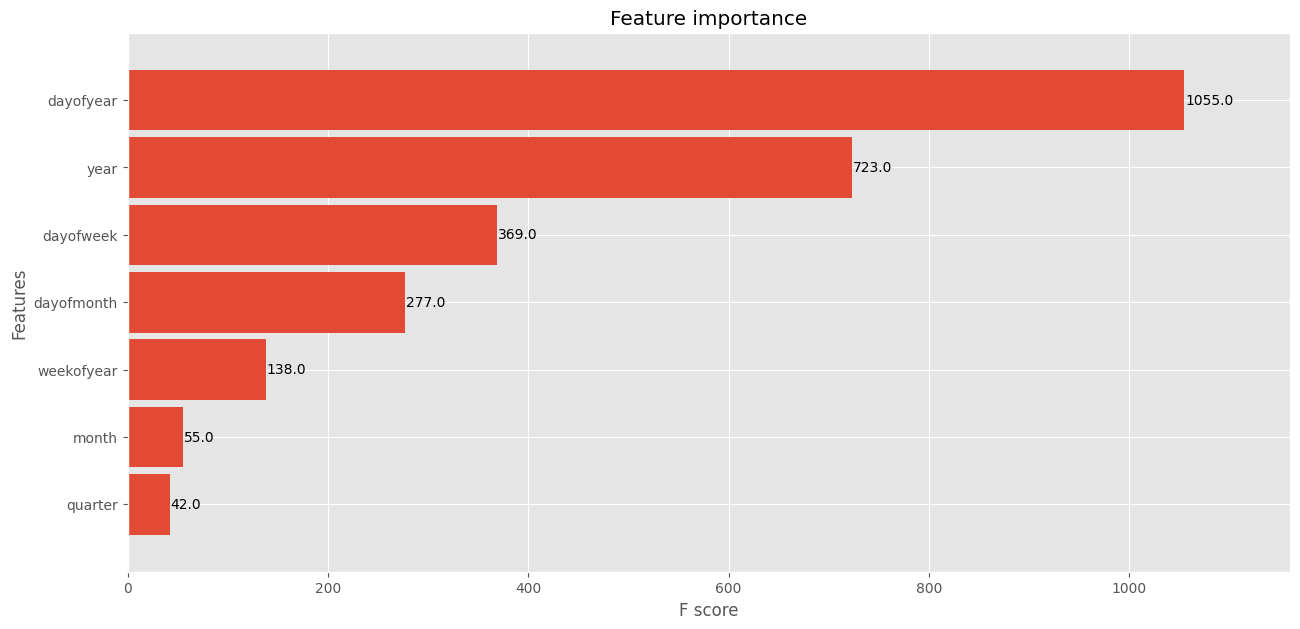

In [ ]:
_ = plot_importance(model, height=0.9)

In [ ]:
test['Prediction'] = model.predict(X_test)
train["Prediction"]= model.predict(X_train)
new_data = pd.concat([train,test], sort=False)

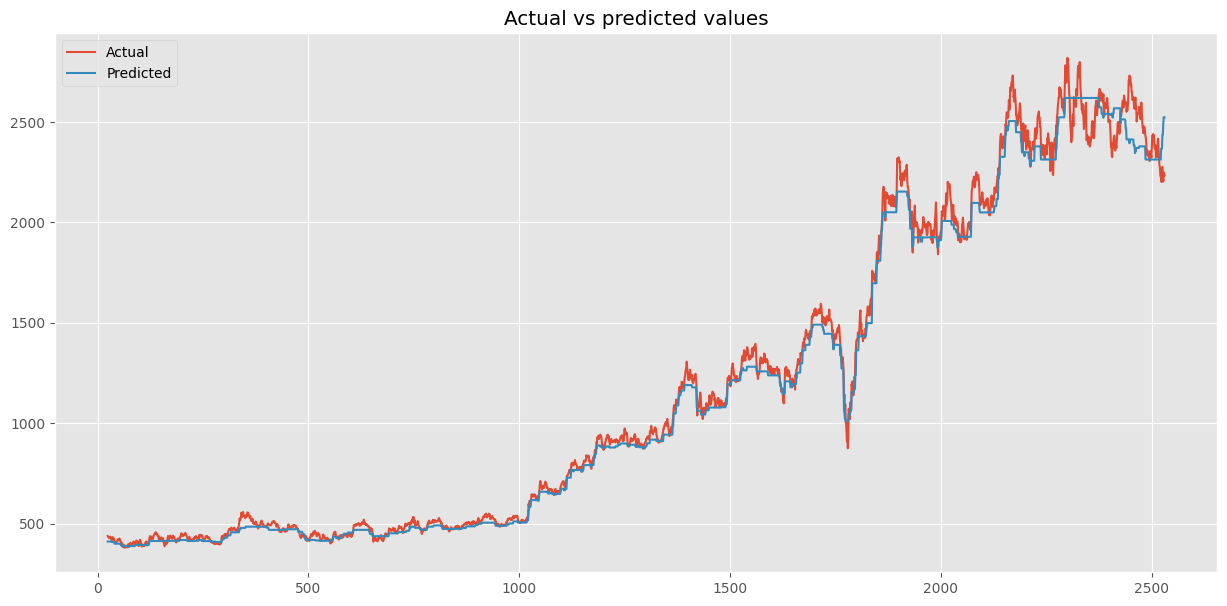

In [ ]:
plt.plot(new_data["Close"], label="Actual")
plt.plot(new_data["Prediction"], label="Predicted")
plt.legend(loc="best")
plt.title("Actual vs predicted values")
plt.show()

In [ ]:
new_data

,Date,Close,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Prediction
24,2013-02-04,439.186951,2013-02-04,0,1,2,2013,35,4,6,411.319916
25,2013-02-05,433.268066,2013-02-05,1,1,2,2013,36,5,6,411.319916
26,2013-02-06,433.713837,2013-02-06,2,1,2,2013,37,6,6,411.319916
27,2013-02-07,432.351746,2013-02-07,3,1,2,2013,38,7,6,411.319916
28,2013-02-08,427.720642,2013-02-08,4,1,2,2013,39,8,6,411.319916
...,...,...,...,...,...,...,...,...,...,...,...
2526,2023-03-23,2247.800049,2023-03-23,3,1,3,2023,82,23,12,2437.126221
2527,2023-03-24,2203.300049,2023-03-24,4,1,3,2023,83,24,12,2489.195557
2528,2023-03-27,2237.550049,2023-03-27,0,1,3,2023,86,27,13,2523.471436
2529,2023-03-28,2248.000000,2023-03-28,1,1,3,2023,87,28,13,2523.471436


In [ ]:
print("Mean absolute error is ",mean_absolute_error(new_data["Close"],new_data["Prediction"]))
print("Mean squared error is ",mean_squared_error(new_data["Close"],new_data["Prediction"]))
print("Mean absolute percentage error is ",mean_absolute_percentage_error(new_data["Close"],new_data["Prediction"]))

Mean absolute error is  41.79696103225892
Mean squared error is  3818.214703340488
Mean absolute percentage error is  3.4243100426592386


## LSTM


In [ ]:
data=data.dropna()

In [ ]:
data.head()

,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9,roll_7,roll_14,roll_25,roll_252,diff_1
24,2013-02-04,439.186951,442.802673,445.477325,444.561005,453.476501,455.705353,442.898198,445.403022,434.785665,415.535967,-3.615722
25,2013-02-05,433.268066,439.186951,439.162170,437.280029,451.817230,457.191284,440.248317,445.877101,435.460271,415.542856,-5.918885
26,2013-02-06,433.713837,433.268066,442.802673,445.477325,444.561005,453.476501,438.698722,445.369415,436.009070,415.651975,0.445771
27,2013-02-07,432.351746,433.713837,439.186951,439.162170,437.280029,451.817230,437.994681,444.403571,436.249789,415.737653,-1.362091
28,2013-02-08,427.720642,432.351746,433.268066,442.802673,445.477325,444.561005,435.458012,442.408201,436.283469,415.757893,-4.631104


In [ ]:
len(data)-252

2277

In [ ]:
train_close= data.iloc[:, 1:2].values[:2277]
test_close=data.iloc[:, 1:2].values[2277:]

In [ ]:
ss= MinMaxScaler(feature_range=(0,1))
train_closed_scaled= ss.fit_transform(train_close)

In [ ]:
xtrain=[]
ytrain=[]
for i in range(60,len(train_closed_scaled)):
    xtrain.append(train_closed_scaled[i-60:i,0])
    ytrain.append(train_closed_scaled[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [ ]:
#initialisizng the model 
model= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
model.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
model.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
model.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
model.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
model.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
model.add(Dropout(0.2))

#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
model.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
model.add(Dense(units=1))

#Compiling the network
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [ ]:
#fitting the network
model.fit(xtrain,ytrain,batch_size=30,epochs=100)

Epoch 1/100
74/74 [==============================] - 45s 295ms/step - loss: 0.0119
Epoch 2/100
74/74 [==============================] - 28s 384ms/step - loss: 0.0034
Epoch 3/100
74/74 [==============================] - 21s 279ms/step - loss: 0.0025
Epoch 4/100
74/74 [==============================] - 14s 186ms/step - loss: 0.0026
Epoch 5/100
74/74 [==============================] - 11s 153ms/step - loss: 0.0023
Epoch 6/100
74/74 [==============================] - 12s 161ms/step - loss: 0.0021
Epoch 7/100
74/74 [==============================] - 11s 152ms/step - loss: 0.0022
Epoch 8/100
74/74 [==============================] - 17s 229ms/step - loss: 0.0022
Epoch 9/100
74/74 [==============================] - 10s 137ms/step - loss: 0.0021
Epoch 10/100
74/74 [==============================] - 11s 146ms/step - loss: 0.0018
Epoch 11/100
74/74 [==============================] - 13s 177ms/step - loss: 0.0021
Epoch 12/100
74/74 [==============================] - 11s 154ms/step - loss: 0.0019
E

In [ ]:
test_close_scaled= ss.fit_transform(test_close)

In [ ]:
xtest=[]
ytest=[]
for i in range(60,len(test_close_scaled)):
    xtest.append(test_close_scaled[i-60:i,0])
    ytest.append(test_close_scaled[i,0])

xtest, ytest = np.array(xtest), np.array(ytest)

In [ ]:
predicted_value=model.predict(xtest)

6/6 [==============================] - 3s 34ms/step


In [ ]:
real_predicted_value=ss.inverse_transform(predicted_value)

In [ ]:
actual_value=test_close[60:]

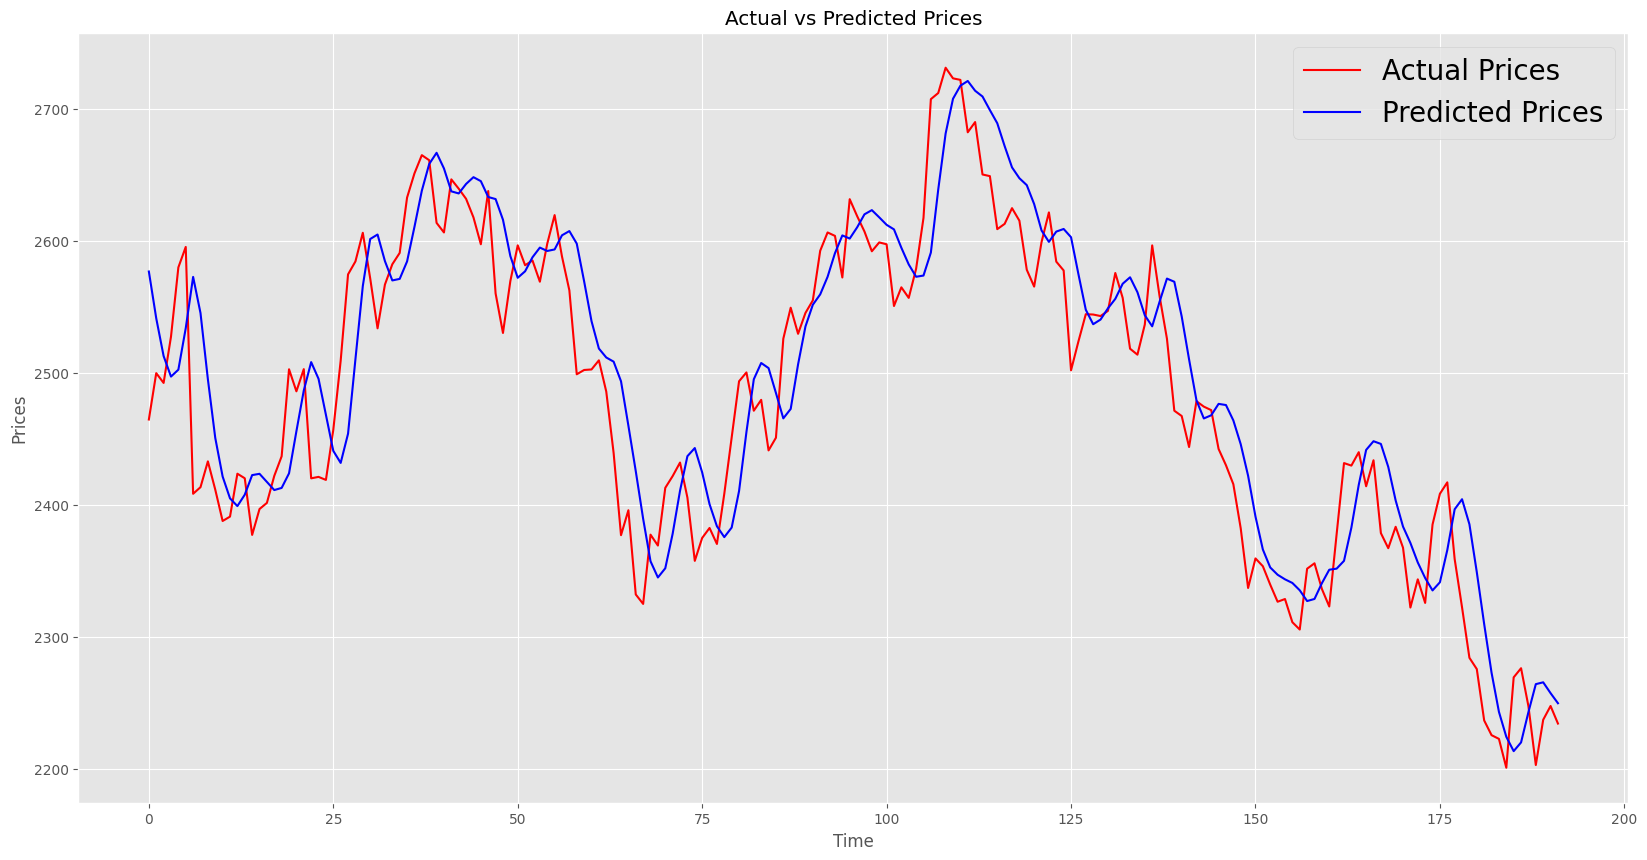

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(actual_value,'red',label='Actual Prices')
plt.plot(real_predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Actual vs Predicted Prices')
plt.legend(loc='best', fontsize=20)
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [ ]:
print("Mean absolute error is ",mean_absolute_error(actual_value,real_predicted_value))
print("Mean squared error is ",mean_squared_error(actual_value,real_predicted_value))
print("Mean absolute percentage error is ",mean_absolute_percentage_error(actual_value,real_predicted_value))

Mean absolute error is  40.18437322517904
Mean squared error is  2483.0970630339975
Mean absolute percentage error is  1.628555150998405
